# Youtube Linear Regression Analysis 
Creator: Riley Cohen 

In this project I will explore and apply linear regression youtube data that I personally scraped off of youtubes API page. In particular I will

1. Perform EDA 
     - Used pandas to read, transform, format and present data 
        - covariance
        - correlations 
    - Use seaborn to visually find relationships between variables and view distributions
        - Pairplot, Heatmap, Barplot, Box plot, displot 
2. Create a Linear Regression model that yields a excellent fit to the data
    - Used scikit learn to 
        - Standardize data
        - Train a linear regression model
        - Use cross validation to analyze performance of model
        - Evaluate rmse, mae, R^2 metrics 
    - Feature Engineered new metrics that dramatically increase the performance of my model
        - Multiplying features 
        - Deleting redundant features 


In [1]:
#Useful Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler
from scipy import stats



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

# First lets read the data.

In [2]:
df1 = pd.read_csv(r'/Users/rileycohen/Desktop/Youtube_Data/Final_data1.csv')
df2 = pd.read_csv(r'/Users/rileycohen/Desktop/Youtube_Data/Final_data2.csv')
df3 = pd.read_csv(r'/Users/rileycohen/Desktop/Youtube_Data/Final_data3.csv')
dfs = [df1,df2,df3]
for df in dfs:
    display(df.head(1))

,Unnamed: 0,id,channelId,categoryId,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,favoriteCount,subscriberCount,videoCount,title,description,channelTitle,comments,url
0,0,Av1xjLtvUl0,UC98tcedR6gULv8_b70WJKyw,10,40285,1053939760,585,5597,163,0,4170000.0,842,Intergalactic (metal cover by Leo Moracchioli),Original by Beastie Boys\n\nYou can buy my alb...,Frog Leap Studios,"Nice one, Leo! This gives me a vibe very simi...",https://www.youtube.com/watch?v=Av1xjLtvUl0


,Unnamed: 0,id,channelId,categoryId,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,favoriteCount,subscriberCount,videoCount,title,description,channelTitle,comments,url
0,0,FA9FWyjkRxc,UCeGiKk9esjkoTWr7NQV1h8A,26.0,262532.0,17176515,923.0,6799.0,160.0,0.0,168000.0,389,ORGANIZING THE HOME EDIT STYLE | EXTREME ORGAN...,"Hey guys, I hope you are ready for this organi...",Til Vacuum Do Us Part,"Hey guys, let me know in the comments if you ...",https://www.youtube.com/watch?v=FA9FWyjkRxc


,Unnamed: 0,id,channelId,categoryId,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,favoriteCount,subscriberCount,videoCount,title,description,channelTitle,comments,url
0,0,jJfCI3FL9WI,UCLxFQD7RvylccQK-jan59jw,10.0,5629349.0,16572732,2582.0,40017.0,1260.0,0.0,42300.0,184,alan 阿蘭(阿兰) - 青藏高原 Tibetan Plateau 藏/中文版 Tibet...,alan阿蘭於2020年環球綜藝秀演唱新編曲藏語+中文版《青藏高原》\n\n\nSpecia...,Wei H.,你是歌手天才 我喜欢 The sick wrinkle archaeologically ...,https://www.youtube.com/watch?v=jJfCI3FL9WI


# Now lets concatenate and do some cleaning.
- Combine dataframes 
- Drop duplicates based in video_id and channelId
- Drop uneeded columns
- Make categoryId's categorical nature more apparent 
- Combine text data for text analysis

In [3]:
pd.set_option('display.float_format', '{:.01g}'.format)
data1 = pd.concat([df1, df2, df3]).reset_index()
print("Starting shape:", data1.shape)
print("There are", data1.duplicated(subset = ['id']).sum(), "duplicates.")
print("There are", data1.shape[0], "videos before dropping duplicates")
data1 = data1.drop_duplicates(subset = ['id']) #Drop duplicates based on video_id
data1 = data1.drop_duplicates(subset = ['channelId']) ###Here 
print("There are", data1.shape[0], "unique videos")
print('There are',len(data1['channelId'].unique()), 'unique channels')
data1 = data1.drop(columns = ['id', 'channelId' , 'Unnamed: 0', 'channelTitle', 'url','index']) #Drop uneeded columns
data1['categoryRank'] = data1['categoryId'].astype(int)
data1['categoryId'] = data1['categoryId'].apply(lambda x: 'category' + str(int(x))) #Make categorical nature more apparent


data1.iloc[:,0:9] = data1.iloc[:,0:9].fillna(0)
data1.iloc[:,9] = data1.iloc[:,9].fillna('none')

data1['text_data'] = data1['comments'].astype(str) + data1['description'].astype(str) + data1['title'].astype(str) #Combine text data
comments = data1['comments'].astype(str)
description = data1['description'].astype(str)
title = data1['title'].astype(str)

data1 = data1.drop(columns = ['title','comments','description']) #Drop uneeded columns

print('Final shape:',data1.shape)
data1.head()

Starting shape: (8634, 18)
There are 1240 duplicates.
There are 8634 videos before dropping duplicates
There are 5203 unique videos
There are 5203 unique channels
Final shape: (5203, 11)


,categoryId,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,favoriteCount,subscriberCount,videoCount,categoryRank,text_data
0,category10,4e+04,1053939760,6e+02,6e+03,2e+02,0,4e+06,842,10,"Nice one, Leo! This gives me a vibe very simi..."
8,category10,2e+07,61621926,6e+03,2e+05,8e+03,0,2e+05,20,10,Artist: Metal Guitar Stuff / Shadowmind<br />...
9,category10,4e+06,25420758,5e+03,7e+04,5e+03,0,1e+05,93,10,Anybody else here becus they needed to find a...
10,category24,3e+04,36573605,4e+02,5e+03,2e+01,0,0,178,24,RIP Metal Legend😔 I wonder how much the cold ...
11,category10,1e+04,105671085,6e+02,2e+03,1e+01,0,6e+05,265,10,Skill berkelas 🤘 Dewa 19 “hanya mimpi” A7x in...


# Let's perfrom some EDA. I will produce some useful visualizations and numeric comparisons to get and idea of the predictive power of the data.

https://influencermarketinghub.com/how-much-do-youtubers-make/
- Accoriding to this link youtubers make about $3-$5 per 1000 views so let's make a new column of our dataframe and call it video_revenue.
- I am going to take the average of the range, $4 for simplicity.
- I will also create a new column called total_revenue to account for the total revenue a channel generates 
- Last I will examine some the summary stats of the data set 

In [4]:
data2 = data1.copy()
data2 = data2.drop(columns = ['favoriteCount','categoryRank']) #Dont need these columns
data2['video_revenue'] = data1['video_view_count']*(4/1000)
data2['total_revenue'] = data1['channel_view_count']*(4/1000)
data2[['video_revenue','total_revenue']]
pd.reset_option('display.float_format')
summary_stats = data2.describe()

for name in summary_stats.columns:
    summary_stats[name] = summary_stats[name].apply(lambda x: '{:,}'.format(x))
    
summary_stats

,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
count,"5,203.0","5,203.0","5,203.0","5,203.0","5,203.0","5,203.0","5,203.0","5,203.0","5,203.0"
mean,"10,949,019.678646935","735,473,184.2565827","5,437.96309821257","89,432.42859888526","5,609.478762252546","1,701,275.540841822","2,664.680184508937","43,796.078714587675","2,941,892.737026341"
std,"94,404,539.94116125","3,695,923,041.4213624","75,477.21972636385","566,036.1617034829","78,122.7030149635","5,855,454.494187418","14,360.645156864732","377,618.1597646451","14,783,692.165685443"
min,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.068
25%,"31,306.0","4,260,051.0",44.0,605.0,20.0,"19,300.0",78.0,125.224,"17,040.203999999998"
50%,"246,642.0","38,805,103.0",254.0,"4,148.0",135.0,"178,000.0",254.0,986.568,"155,220.412"
75%,"2,197,528.0","276,958,005.5","1,287.0","28,121.0","1,167.5","1,030,000.0",856.0,"8,790.112000000001","1,107,832.0219999999"
max,"4,060,920,665.0","139,019,310,211.0","4,654,081.0","15,697,616.0","5,143,844.0","167,000,000.0","498,154.0","16,243,682.66","556,077,240.844"


Below is a functions that will standardize the data and remove any outliers. This will put all the columns on a similar scale, thus making the visualization a little bit better.

In [5]:
def standardize(data):
    '''
    Input: Dataframe 
    Output: Standardized dataframe without outliers
    '''
    ss = StandardScaler()
    col_names = data.columns
    indx = data.index
    data = pd.DataFrame(ss.fit_transform(data)) #Standardize 
    data.set_index(indx, inplace = True)
    data.columns = col_names
    data = data[(np.abs(stats.zscore(data)) < 2.5).all(axis = 1)] #Remove outliers
    
    return data

Let's take quick view at the relationships between all the numeric variables 

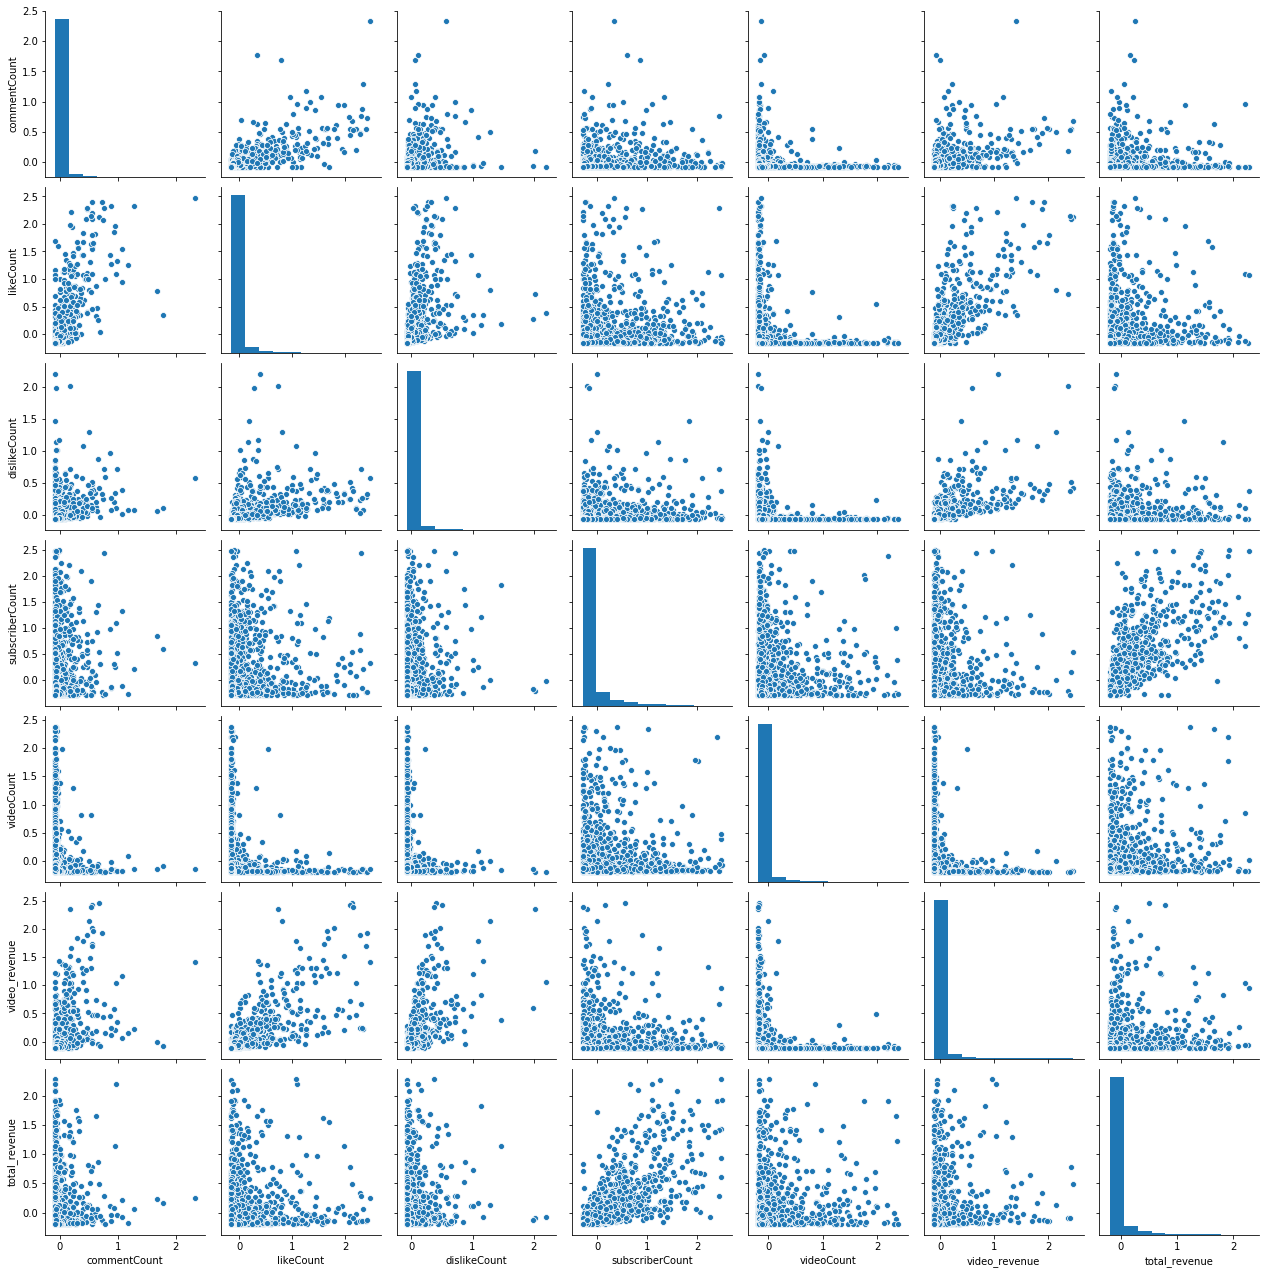

In [6]:
sns.pairplot(standardize(data2[summary_stats.columns].iloc[:,2:]));

Looks like there is some strong linear assosciation between the variables. There may be some predictive power.

Let's check out the covariance to get a numerical sense of how two variable interact with each other. The higher the covariance the stronger the interaction.

In [7]:
standardize(data2[summary_stats.columns].iloc[:,2:]).cov()

,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
commentCount,0.010400,0.019206,0.004505,0.009028,-0.000580,0.010306,0.005024
likeCount,0.019206,0.059946,0.014384,0.022809,-0.003019,0.035756,0.014176
dislikeCount,0.004505,0.014384,0.011389,0.009644,-0.000826,0.013763,0.006774
subscriberCount,0.009028,0.022809,0.009644,0.132850,0.018226,0.011574,0.073936
videoCount,-0.000580,-0.003019,-0.000826,0.018226,0.061577,-0.001834,0.017854
video_revenue,0.010306,0.035756,0.013763,0.011574,-0.001834,0.034481,0.011295
total_revenue,0.005024,0.014176,0.006774,0.073936,0.017854,0.011295,0.066037


Looks like there is very little interaction, but let's look at a heat map to get a better sense of this. Lighter colors indicate a larger interaction.

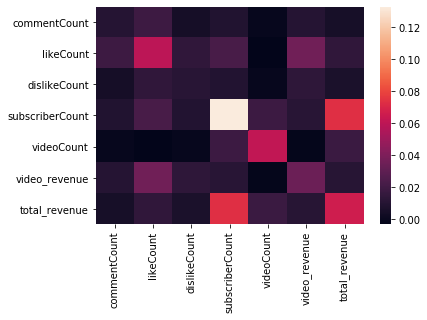

In [8]:
sns.heatmap(standardize(data2[summary_stats.columns].iloc[:,2:]).cov());

There is a bit more than I initially thought.

Now lets explore the relationships between the numeric variables
- Correlations with a correlation coefficients larger than 0.5
- Distributions for the numnerical variables

In [9]:
correlations = data2.corr() > .5
corr_index = correlations.index
corr_columns = correlations.columns
correlations

,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
video_view_count,True,False,False,True,False,False,False,True,False
channel_view_count,False,True,False,False,False,True,False,False,True
commentCount,False,False,True,True,False,False,False,False,False
likeCount,True,False,True,True,False,False,False,True,False
dislikeCount,False,False,False,False,True,False,False,False,False
subscriberCount,False,True,False,False,False,True,False,False,True
videoCount,False,False,False,False,False,False,True,False,False
video_revenue,True,False,False,True,False,False,False,True,False
total_revenue,False,True,False,False,False,True,False,False,True


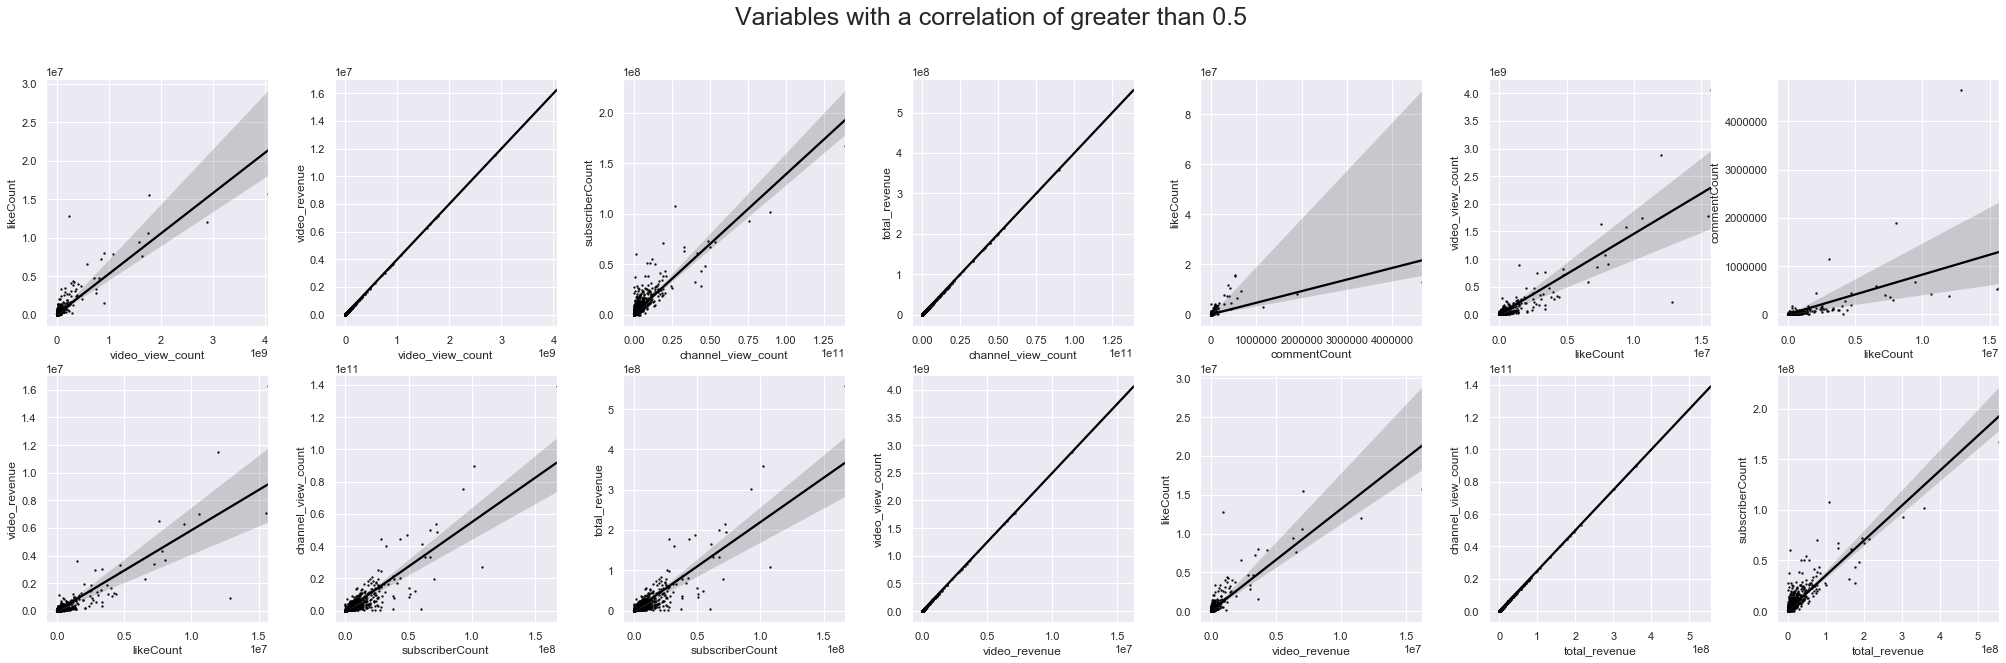

In [10]:
true_indices = np.where(correlations == True)
filtered_true_indices = np.where((true_indices[0] != true_indices[1]) == True)
#filtered_true_indices = np.where((true_indices[0] > true_indices[1]) == True)
row_idx = true_indices[0][filtered_true_indices]
column_idx = true_indices[1][filtered_true_indices]
number_of_images = (true_indices[0] != true_indices[1]).sum()

sns.set(font_scale=1)
f,axes = plt.subplots(2,7,figsize=(35, 10))
for k in np.arange(0,int(number_of_images),1): #int(number_of_images/2)
    plt.subplot(2,7,k+1)
    i = corr_index[row_idx[k]]
    j = corr_columns[column_idx[k]]
    #sns.scatterplot(x = i, y = j, data = data2)
    #h = sns.jointplot(data = data2, x = i, y = j , kind='hex', color='r')
    sns.regplot(data = data2,x = i,y = j, scatter = True ,color='black',
               marker='o', scatter_kws={'s':2});
f.subplots_adjust(wspace=.3);
f.subplots_adjust(hspace=.2);
f.suptitle('Variables with a correlation of greater than 0.5',size=25); # or plt.suptitle('Main title')

The lines above that have no shaded region indicate a perfectly linear fit.

Let's examine the distributions of the text lengths.

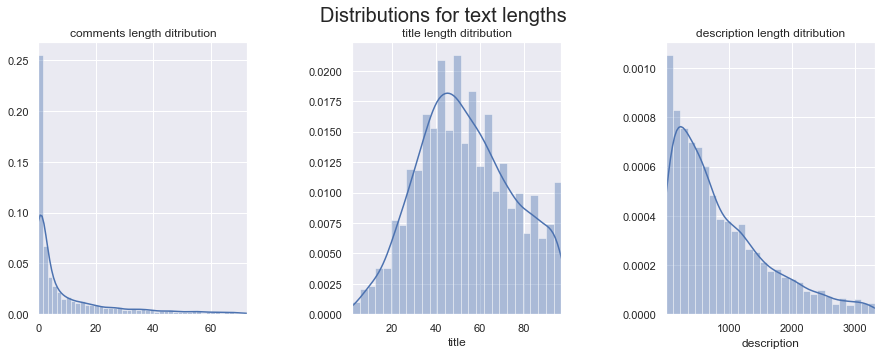

In [11]:
sns.set(font_scale=1)
f,axes = plt.subplots(1,3,figsize=(15, 5))

series = [(comments.apply(len)/data1['commentCount']).replace([np.inf, -np.inf], 0).fillna(0), 
          title.apply(len), 
          description.apply(len)]
names = ['comments length', 'title length', 'description length']
for k in range(3):
    plt.subplot(1,3,k+1)
    x = series[k]
    x = x[x.between(x.quantile(0), x.quantile(.95))]
    s = sns.distplot(x);
    plt.title(names[k] +' ditribution');
    plt.xlim((x.min(), x.max()));
f.subplots_adjust(wspace=.5);
f.subplots_adjust(hspace=.5);
f.suptitle('Distributions for text lengths',size=20);

Let's examine the distributions of the numeric variables.

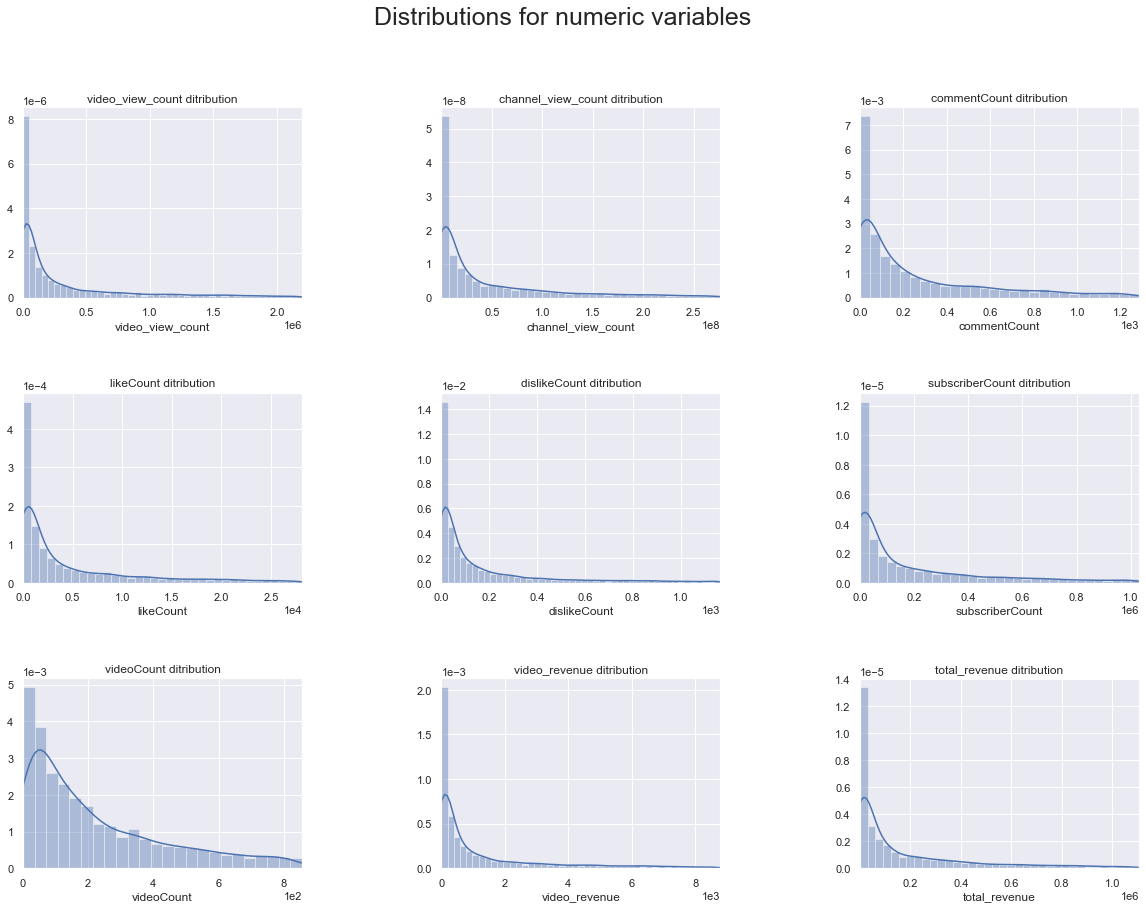

In [12]:
sns.set(font_scale=1)
f,axes = plt.subplots(3,3,figsize=(20, 14))
l = len(corr_columns)
for k in np.arange(0,l,1):
    plt.subplot(3,3,k+1)
    name = corr_columns[k]
    x = data2[name]
    x = x[x.between(x.quantile(0), x.quantile(.75))] #Removes outliers in some sense - Helps visualization
    s = sns.distplot(x);
    plt.title(name +' ditribution');
    plt.xlim((x.min(), x.max()))
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
f.subplots_adjust(wspace=.5);
f.subplots_adjust(hspace=.5);
f.suptitle('Distributions for numeric variables',size=25);

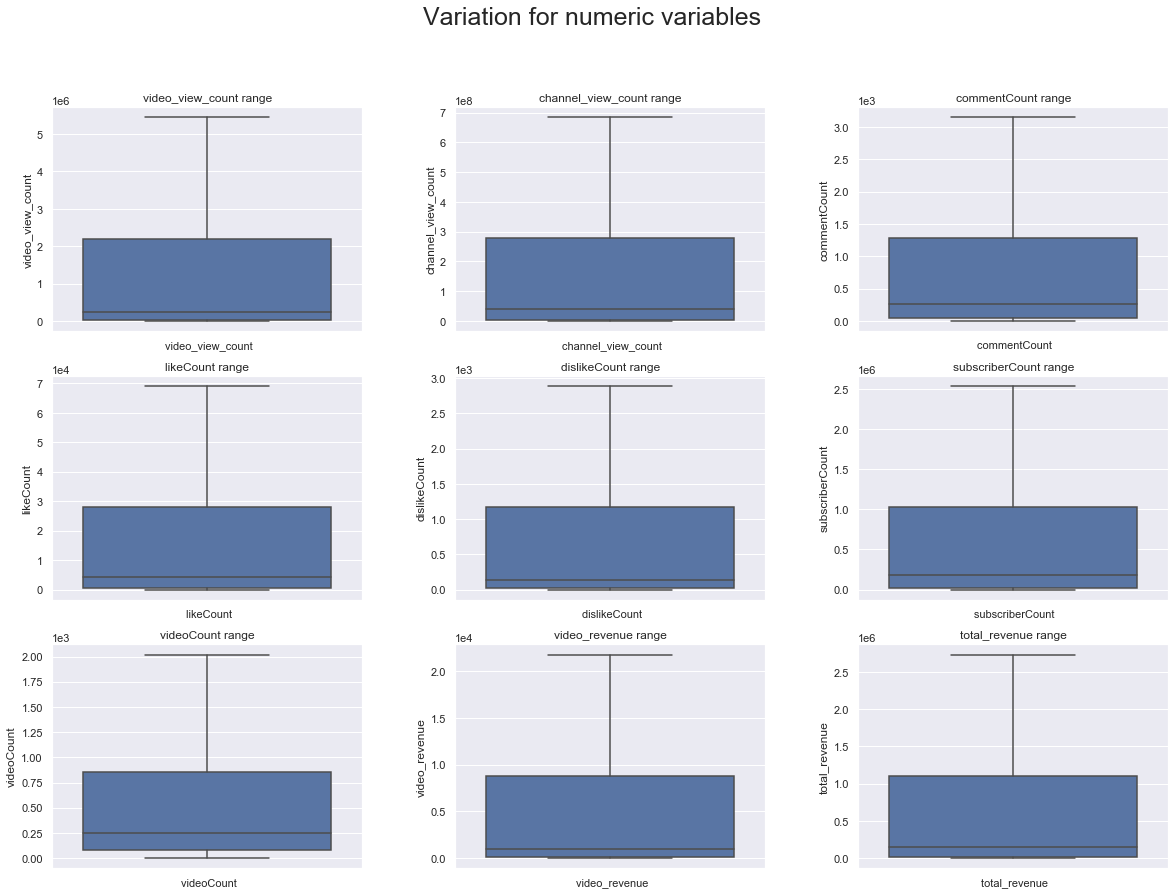

In [13]:
boxpt = data2.copy()
for k in corr_columns:
    boxpt[" "+k] = boxpt[k].apply(lambda x: " "+k)

sns.set(font_scale=1)
f,axes = plt.subplots(3,3,figsize=(20, 14))
l = len(corr_columns)
for k in np.arange(0,l,1):
    plt.subplot(3,3,k+1)
    name = corr_columns[k]
    sns.boxplot(x=" "+name, y=name, data=boxpt,showfliers=False)
    plt.xlabel('')
    plt.title(name +' range');
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
f.subplots_adjust(wspace=.3);
f.subplots_adjust(hspace=.2);
f.suptitle('Variation for numeric variables',size=25);

In [14]:
ordered_categories = data1['categoryRank'].value_counts().reset_index().sort_values(by='index')
index = ordered_categories['index'].index
ordered_categories.head()

,index,categoryRank
8,1,209
10,2,113
0,10,1171
14,15,35
9,17,174


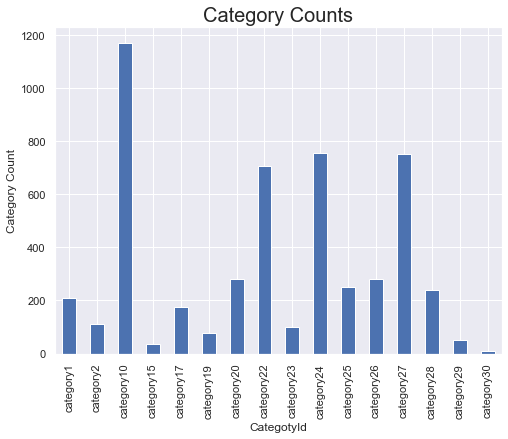

In [15]:
plt.figure(figsize=(8, 6))
data1['categoryId'].value_counts()[index].plot(kind="bar")
plt.xlabel('CategotyId')
plt.ylabel("Category Count")
plt.title("Category Counts", size = 20);

We can see that category 10, 24, 27 and 22 have the most videos in this data set.

Now let's see numerical variable counts for each category.

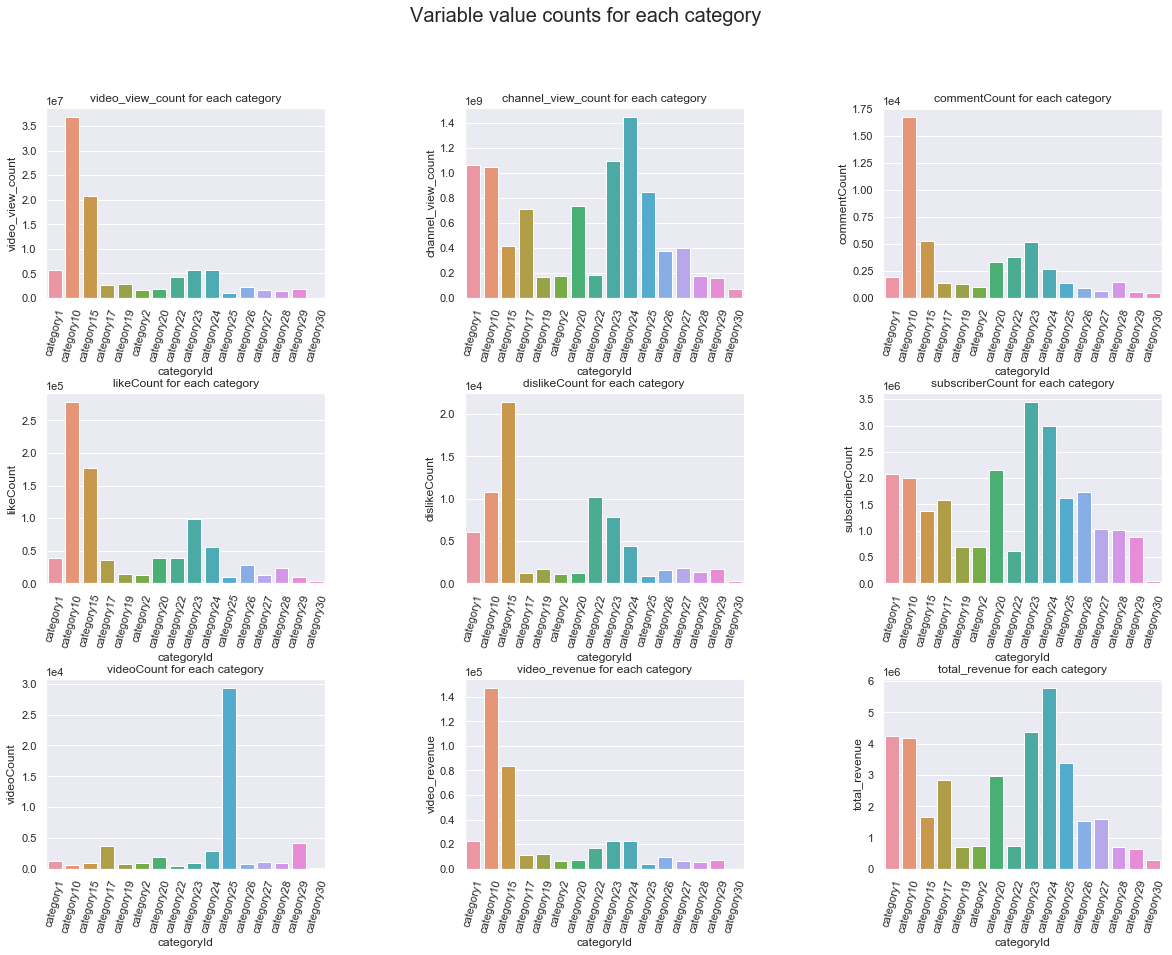

In [16]:
category = data2.groupby(by = 'categoryId').mean()
colms = category.columns
category['categoryId'] = category.index
f,axes = plt.subplots(3,3,figsize=(20, 14))
k = 0
for col in colms:
    k+=1
    plt.subplot(3,3,k)
    #category = category.reset_index().sort_values(by = col, ascending = False).drop(columns = )
    #temp = category.copy().sort_values(by = col, ascending = False)
    temp = category 
    sns.barplot(x = temp['categoryId'], y = temp[col], data=temp)
    plt.title(col+' for each category')
    plt.xticks(rotation=75);  
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
f.subplots_adjust(wspace=.5);
f.subplots_adjust(hspace=.5);
f.suptitle('Variable value counts for each category', size = 20);

Talk about plots above and relation to original count plot

Commentary here

Let's train a Linear Regression model with the current numeric data we have and see how well it does. Let's predict each column and use the evaluate out data by checking the RMSE, MAE and $R^{2}$ coefficient.

In [17]:
design1 = data2.copy().drop(columns = ['categoryId','text_data']).astype(float) #Dont need these columns 
print('Shape:', design1.shape)
design1.head()

Shape: (5203, 9)


,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
0,40285.0,1.053940e+09,585.0,5597.0,163.0,4170000.0,842.0,161.140,4215759.040
8,15894385.0,6.162193e+07,5590.0,156506.0,8131.0,171000.0,20.0,63577.540,246487.704
9,3699960.0,2.542076e+07,4990.0,69538.0,4560.0,103000.0,93.0,14799.840,101683.032
10,32136.0,3.657360e+07,402.0,4663.0,19.0,0.0,178.0,128.544,146294.420
11,13355.0,1.056711e+08,585.0,1556.0,11.0,560000.0,265.0,53.420,422684.340


Let's split the data and initialize the model

In [18]:
#Train test split
x_train1, x_test1 = train_test_split(design1, test_size=0.1, random_state=42)
model = LinearRegression()

Below are some useful functions for this analysis.

In [19]:
def cross_validate(model, X, y, metric):
    '''
    Input: un-trained model, training matrix, training response, metric function we wish to comput
    Output: Cross-Validation Metric
    '''
    model = clone(model)
    five_fold = KFold(n_splits=5)
    metric_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        metric_values.append(metric(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(metric_values)


def standardize(data):
    '''
    Input: Dataframe 
    Output: Standardized dataframe without outliers
    '''
    ss = StandardScaler()
    col_names = data.columns
    indx = data.index
    data = pd.DataFrame(ss.fit_transform(data)) #Standardize 
    data.set_index(indx, inplace = True)
    data.columns = col_names
    data = data[(np.abs(stats.zscore(data)) < 2.5).all(axis = 1)] #Remove outliers
    
    return data
    

def test_model1(model, x_train, col):
    '''
    This function trains the model and computes the desired training and cross validated metrics
    
    Input:  col - represents column name as a string
            model - untrained model
            x_train - design matrix used for training 
    Output: train_rmse, cv_rmse, train_mae, cv_mae , train_r2, cv_r2
    
    '''
    #Create design matrix and predictor 
    model = clone(model)
    x_train, y_train = x_train.drop(columns = [col]), x_train[col]
    x_train = standardize(x_train) ###HERE
    y_train = y_train[x_train.index]

    
    #Compute metrics using CV to get a sense of how the model will do on the test set
    cv_mse = cross_validate(model, x_train, y_train, mse)
    cv_mae = cross_validate(model, x_train, y_train, mae)
    cv_r2 = cross_validate(model, x_train, y_train, r2_score)

    #Fit, predict and compute metrics on training set
    model.fit(x_train, y_train)
    y_pred = model.predict(x_train)
    train_mse = mse(y_pred, y_train)
    train_r2 = r2_score(y_pred, y_train)

    return pd.DataFrame([[np.sqrt(train_mse), np.sqrt(cv_mse), train_r2, cv_r2]], 
                        columns = ['train_rmse', 'cv_rmse', 'train_r2', 'cv_r2']) 


def redundant_features(df):
    '''
    Input: Dataframe
    Output: Dataframe without redundant features
    '''
    
    correlated_features = set()
    correlation_matrix = df.iloc[:,10:].corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > 0.8:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    df.drop(labels=correlated_features, axis=1, inplace=True)
    
    return df
           

Let's compute the metrics on the training data.
- The cross validated metrics are here to give me a sense of 
    1. How the model might perfrom on the test set 
    2. If the model is overfitting 

In [20]:
metrics1 = pd.concat([test_model1(model, x_train1.iloc[:,2:], col) for col in design1.columns[2:]])
metrics1['predictor'] = x_train1.iloc[:,2:].columns
metrics1 = metrics1.set_index('predictor')
metrics1

,train_rmse,cv_rmse,train_r2,cv_r2
predictor,,,,
commentCount,4.447863e+03,4.501823e+03,0.198620,0.560823
likeCount,7.132372e+04,7.389102e+04,0.691350,0.748554
dislikeCount,6.726419e+03,7.359002e+03,-0.282059,0.353998
subscriberCount,1.951783e+06,1.976101e+06,0.284985,0.569057
videoCount,1.380162e+04,1.385381e+04,-12.750120,0.049284
video_revenue,3.681509e+04,3.745335e+04,0.638180,0.722966
total_revenue,2.599221e+06,2.623080e+06,0.470311,0.641374


Here is summary of the results:
- $R^{2}$ values closer to 1 indicate a good fit, so likeCount and video Revenue are easiest to fit with the current data.

Looks like we have some work to do :-)

Let's create a new design matrix, which we will feature engineer.


In [21]:
design2 = design1.copy()
#design2['categoryId'] = data1['categoryRank']
design2.head()

,video_view_count,channel_view_count,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
0,40285.0,1.053940e+09,585.0,5597.0,163.0,4170000.0,842.0,161.140,4215759.040
8,15894385.0,6.162193e+07,5590.0,156506.0,8131.0,171000.0,20.0,63577.540,246487.704
9,3699960.0,2.542076e+07,4990.0,69538.0,4560.0,103000.0,93.0,14799.840,101683.032
10,32136.0,3.657360e+07,402.0,4663.0,19.0,0.0,178.0,128.544,146294.420
11,13355.0,1.056711e+08,585.0,1556.0,11.0,560000.0,265.0,53.420,422684.340


Recalll video_view_count& channel_view_count are linear combninations of video_revenue & total_revenue respectively, so I am going to remove the former two.

In [22]:
design2 = design2.iloc[:, 2:]
print(design2.shape)
design2.head()

(5203, 7)


,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue
0,585.0,5597.0,163.0,4170000.0,842.0,161.140,4215759.040
8,5590.0,156506.0,8131.0,171000.0,20.0,63577.540,246487.704
9,4990.0,69538.0,4560.0,103000.0,93.0,14799.840,101683.032
10,402.0,4663.0,19.0,0.0,178.0,128.544,146294.420
11,585.0,1556.0,11.0,560000.0,265.0,53.420,422684.340


Now let's create some new features by multiplying pre-existing features.

In [23]:
from itertools import combinations
column_list = design2.columns
interactions = list(combinations(column_list, 2))
interactions

[('commentCount', 'likeCount'),
 ('commentCount', 'dislikeCount'),
 ('commentCount', 'subscriberCount'),
 ('commentCount', 'videoCount'),
 ('commentCount', 'video_revenue'),
 ('commentCount', 'total_revenue'),
 ('likeCount', 'dislikeCount'),
 ('likeCount', 'subscriberCount'),
 ('likeCount', 'videoCount'),
 ('likeCount', 'video_revenue'),
 ('likeCount', 'total_revenue'),
 ('dislikeCount', 'subscriberCount'),
 ('dislikeCount', 'videoCount'),
 ('dislikeCount', 'video_revenue'),
 ('dislikeCount', 'total_revenue'),
 ('subscriberCount', 'videoCount'),
 ('subscriberCount', 'video_revenue'),
 ('subscriberCount', 'total_revenue'),
 ('videoCount', 'video_revenue'),
 ('videoCount', 'total_revenue'),
 ('video_revenue', 'total_revenue')]

In [24]:
starting_df = pd.DataFrame(np.ones(len(design2)))
column_name = []
for k in interactions:
    new_feature = (design2[k[0]] * design2[k[1]]).to_frame().reset_index().drop(columns = ['index'])
    column_name.append(k[0] + ' * ' + k[1])
    starting_df = pd.concat([starting_df, new_feature], axis = 1)
inters_df = starting_df.iloc[:,1:].reset_index().drop(columns = ['index'])
inters_df.columns = column_name

inters_df.head()

,commentCount * likeCount,commentCount * dislikeCount,commentCount * subscriberCount,commentCount * videoCount,commentCount * video_revenue,commentCount * total_revenue,likeCount * dislikeCount,likeCount * subscriberCount,likeCount * videoCount,likeCount * video_revenue,...,dislikeCount * subscriberCount,dislikeCount * videoCount,dislikeCount * video_revenue,dislikeCount * total_revenue,subscriberCount * videoCount,subscriberCount * video_revenue,subscriberCount * total_revenue,videoCount * video_revenue,videoCount * total_revenue,video_revenue * total_revenue
0,3274245.0,95355.0,2.439450e+09,492570.0,9.426690e+04,2.466219e+09,9.123110e+05,2.333949e+10,4712674.0,9.019006e+05,...,6.797100e+08,137246.0,2.626582e+04,6.871687e+08,3.511140e+09,6.719538e+08,1.757972e+13,135679.880,3.549669e+09,6.793274e+08
1,874868540.0,45452290.0,9.558900e+08,111800.0,3.553984e+08,1.377866e+09,1.272550e+09,2.676253e+10,3130120.0,9.950266e+09,...,1.390401e+09,162620.0,5.169490e+08,2.004192e+09,3.420000e+06,1.087176e+10,4.214940e+10,1271550.800,4.929754e+06,1.567108e+10
2,346994620.0,22754400.0,5.139700e+08,464070.0,7.385120e+07,5.073983e+08,3.170933e+08,7.162414e+09,6467034.0,1.029151e+09,...,4.696800e+08,424080.0,6.748727e+07,4.636746e+08,9.579000e+06,1.524384e+09,1.047335e+10,1376385.120,9.456522e+06,1.504893e+09
3,1874526.0,7638.0,0.000000e+00,71556.0,5.167469e+04,5.881036e+07,8.859700e+04,0.000000e+00,830014.0,5.994007e+05,...,0.000000e+00,3382.0,2.442336e+03,2.779594e+06,0.000000e+00,0.000000e+00,0.000000e+00,22880.832,2.604041e+07,1.880527e+07
4,910260.0,6435.0,3.276000e+08,155025.0,3.125070e+04,2.472703e+08,1.711600e+04,8.713600e+08,412340.0,8.312152e+04,...,6.160000e+06,2915.0,5.876200e+02,4.649528e+06,1.484000e+08,2.991520e+07,2.367032e+11,14156.300,1.120114e+08,2.257980e+07


(5203, 19)


,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue,commentCount * likeCount,commentCount * dislikeCount,commentCount * subscriberCount,commentCount * videoCount,commentCount * video_revenue,commentCount * total_revenue,likeCount * dislikeCount,likeCount * videoCount,dislikeCount * subscriberCount,subscriberCount * videoCount,subscriberCount * total_revenue,videoCount * video_revenue
0,585.0,5597.0,163.0,4170000.0,842.0,161.140,4215759.040,3274245.0,95355.0,2.439450e+09,492570.0,9.426690e+04,2.466219e+09,9.123110e+05,4712674.0,6.797100e+08,3.511140e+09,1.757972e+13,135679.880
1,5590.0,156506.0,8131.0,171000.0,20.0,63577.540,246487.704,874868540.0,45452290.0,9.558900e+08,111800.0,3.553984e+08,1.377866e+09,1.272550e+09,3130120.0,1.390401e+09,3.420000e+06,4.214940e+10,1271550.800
2,4990.0,69538.0,4560.0,103000.0,93.0,14799.840,101683.032,346994620.0,22754400.0,5.139700e+08,464070.0,7.385120e+07,5.073983e+08,3.170933e+08,6467034.0,4.696800e+08,9.579000e+06,1.047335e+10,1376385.120
3,402.0,4663.0,19.0,0.0,178.0,128.544,146294.420,1874526.0,7638.0,0.000000e+00,71556.0,5.167469e+04,5.881036e+07,8.859700e+04,830014.0,0.000000e+00,0.000000e+00,0.000000e+00,22880.832
4,585.0,1556.0,11.0,560000.0,265.0,53.420,422684.340,910260.0,6435.0,3.276000e+08,155025.0,3.125070e+04,2.472703e+08,1.711600e+04,412340.0,6.160000e+06,1.484000e+08,2.367032e+11,14156.300


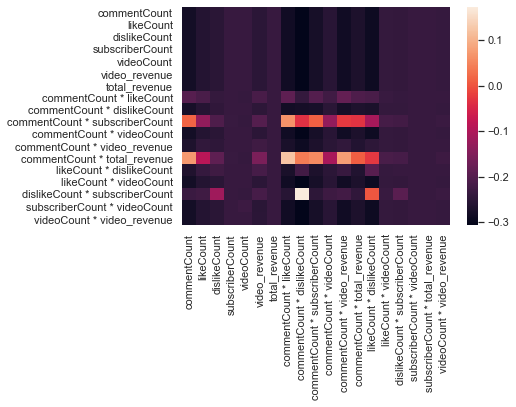

In [25]:
design3 = pd.concat([design2.reset_index().drop(columns = ['index']), inters_df] , axis = 1)
design3 = redundant_features(design3) #Remove redundant features 
print(design3.shape)
display(design3.head())
sns.heatmap(standardize(design3.cov()));

Looks like we have some new and useful relationship! :-)

Let's compute the metrics using our new design matrix.

In [26]:
#Train test splot
x_train2, x_test2 = train_test_split(design3, test_size=0.1, random_state=42)
model = LinearRegression()

In [27]:
metrics2 = pd.concat([test_model1(model, x_train2, col) for col in design1.columns[2:]])
metrics2['predictor'] = design1.columns[2:]
metrics2 = metrics2.set_index('predictor')

In [28]:
from IPython.display import display_html
def display_side_by_side(*args):
    '''
    Displays dataframes side by side 
    '''
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
display_side_by_side(metrics1, metrics2)

,train_rmse,cv_rmse,train_r2,cv_r2
predictor,,,,
commentCount,4.447863e+03,4.501823e+03,0.198620,0.560823
likeCount,7.132372e+04,7.389102e+04,0.691350,0.748554
dislikeCount,6.726419e+03,7.359002e+03,-0.282059,0.353998
subscriberCount,1.951783e+06,1.976101e+06,0.284985,0.569057
videoCount,1.380162e+04,1.385381e+04,-12.750120,0.049284
video_revenue,3.681509e+04,3.745335e+04,0.638180,0.722966
total_revenue,2.599221e+06,2.623080e+06,0.470311,0.641374
,train_rmse,cv_rmse,train_r2,cv_r2
predictor,,,,


It is very clear that the second model is out performing the first because the errors are much less AND the R^2 score is closer to 1, thus indicating a better fit.

Before I fit each model on the actual test data, I am going to apply two more feature tactic, namely, 
- polynomial featurization
- One hot encoding the video cateogories


It is worth noting that I applied CountVectorizer to the text data but that it only negatively impacted the model.

In [29]:
#Polynomial featurization
design4 = design3.copy()
for feature in design4.columns:
    for p in range(2, 8):
        design4['(' + feature + ')^' + str(p)] = design4[feature] ** p

#One hot encode 
one_hot_categories = pd.get_dummies(data1['categoryId'])
print(one_hot_categories.shape)
one_hot_categories.head()

design4 = pd.concat([design4,one_hot_categories.reset_index().drop(columns = ['index'])], axis = 1)
design4 = redundant_features(design4)
print(design4.shape)

design4.head()

(5203, 16)
(5203, 36)


,commentCount,likeCount,dislikeCount,subscriberCount,videoCount,video_revenue,total_revenue,commentCount * likeCount,commentCount * dislikeCount,commentCount * subscriberCount,...,category20,category22,category23,category24,category25,category26,category27,category28,category29,category30
0,585.0,5597.0,163.0,4170000.0,842.0,161.140,4215759.040,3274245.0,95355.0,2.439450e+09,...,0,0,0,0,0,0,0,0,0,0
1,5590.0,156506.0,8131.0,171000.0,20.0,63577.540,246487.704,874868540.0,45452290.0,9.558900e+08,...,0,0,0,0,0,0,0,0,0,0
2,4990.0,69538.0,4560.0,103000.0,93.0,14799.840,101683.032,346994620.0,22754400.0,5.139700e+08,...,0,0,0,0,0,0,0,0,0,0
3,402.0,4663.0,19.0,0.0,178.0,128.544,146294.420,1874526.0,7638.0,0.000000e+00,...,0,0,0,1,0,0,0,0,0,0
4,585.0,1556.0,11.0,560000.0,265.0,53.420,422684.340,910260.0,6435.0,3.276000e+08,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#Train test split
x_train3, x_test3 = train_test_split(design4, test_size=0.1, random_state=42)
model = LinearRegression()

In [31]:
metrics3 = pd.concat([test_model1(model, x_train3, col) for col in design1.columns[2:]])
metrics3['predictor'] = design1.columns[2:]
metrics3 = metrics3.set_index('predictor')

In [32]:
pd.set_option('display.float_format', '{:.4g}'.format)
display_side_by_side(metrics2, metrics3)

,train_rmse,cv_rmse,train_r2,cv_r2
predictor,,,,
commentCount,1718,1860,0.9103,0.9017
likeCount,3.978e+04,5.354e+04,0.9113,0.8599
dislikeCount,3028,4362,0.8623,0.7658
subscriberCount,1.345e+06,1.417e+06,0.7425,0.7398
videoCount,5785,6167,-0.07062,0.3335
video_revenue,1.96e+04,2.143e+04,0.9096,0.8929
total_revenue,1.467e+06,1.537e+06,0.8606,0.8648
,train_rmse,cv_rmse,train_r2,cv_r2
predictor,,,,


There is not muhc of a difference, except for the estimate on the video count prediction. It's time to test the models on the test data!

Below I define a couple functions to evaluate the test data.

In [33]:
def metrics(y_pred, y_true):
    '''
    Input: predicted response, true response
    Output: rmse, mae, R^2
    '''
    
    rmse = np.sqrt(mse(y_pred, y_true))
    r2 = r2_score(y_pred, y_true)

    return pd.DataFrame([[rmse, r2]], 
                        columns = ['rmse', 'R^2'])

def test_model2(model, x_test, col):
    '''
    Input:  col - represents column name as a string
            model - 
    Output: Print MSE and accuracy for training and test set
    
    '''
    #Create design matrix and predictor 
    model = clone(model)
    y_test = x_test[col]
    x_test = x_test.drop(columns = [col])

    #Fit, predict and compute metrics on training set
    model.fit(x_test, y_test)
    y_pred = model.predict(x_test)

    return metrics(y_pred, y_test)



In [34]:
model = LinearRegression()
test_metrics1 = pd.concat([test_model2(model, x_test1.iloc[:,2:], col) for col in design1.columns[2:]])
test_metrics1['predictor'] = design1.columns[2:]
test_metrics1 = test_metrics1.set_index('predictor')


test_metrics2 = pd.concat([test_model2(model, x_test2, col) for col in design1.columns[2:]])
test_metrics2['predictor'] = design1.columns[2:]
test_metrics2 = test_metrics2.set_index('predictor')



test_metrics3 = pd.concat([test_model2(model, x_test3, col) for col in design1.columns[2:]])
test_metrics3['predictor'] = design1.columns[2:]
test_metrics3 = test_metrics3.set_index('predictor')


pd.set_option('display.float_format', '{:.4g}'.format)
display_side_by_side(test_metrics1, test_metrics2, test_metrics3)

,rmse,R^2
predictor,,
commentCount,4832,0.9788
likeCount,1.101e+05,0.9871
dislikeCount,2.417e+04,0.7328
subscriberCount,1.617e+06,0.8985
videoCount,1.017e+04,-147.5
video_revenue,2.031e+05,0.9463
total_revenue,3.965e+06,0.8908
,rmse,R^2
predictor,,


- All models actually performed very well, however the third model is clearly the best. All had a bit of trouble prediciting the video count.

- It should be noted that the errors are so large because we are working with very large numbers and a large number of samples. Relatively speaking, these errors are actually not large.
    - It is visually easier to compare these models based on the $R^{2}$ value


Below is a a dataframe named compare that shows which model performed better. Entry compare$ _{ij}$ corresponds to the model the performed better for predictor i and metric j.

In [35]:
compare1 = test_metrics3.iloc[:,0:1] < test_metrics2.iloc[:,0:1] #Smaller error?
compare2 = abs(1 - test_metrics3[['R^2']]) < abs(1 - test_metrics2[['R^2']]) #Closer to 1?
compare = pd.concat([compare1, compare2], axis = 1).replace(True, 'Model 2').replace(False, 'Model 1')
compare

,rmse,R^2
predictor,,
commentCount,Model 2,Model 2
likeCount,Model 2,Model 2
dislikeCount,Model 2,Model 2
subscriberCount,Model 2,Model 2
videoCount,Model 2,Model 2
video_revenue,Model 2,Model 2
total_revenue,Model 2,Model 2


As you can see, model 2 is far more superior. Let's take this analysis one step further by seeing the percent changes in the metrics.


In [36]:
compare1 = (test_metrics3.iloc[:,0:1] - test_metrics2.iloc[:,0:1])/test_metrics2.iloc[:,0:1] 
compare2 = (test_metrics3[['R^2']] - test_metrics2[['R^2']])/test_metrics2[['R^2']] 
compare = pd.concat([compare1, compare2], axis = 1)
compare * 100

,rmse,R^2
predictor,,
commentCount,-1.064,0.02546
likeCount,-1.309,0.008023
dislikeCount,-1.323,0.01546
subscriberCount,-0.6381,0.08008
videoCount,-34.93,24.94
video_revenue,-0.8982,0.002317
total_revenue,-4.728,0.2073
